In [23]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

%load_ext autoreload
%aimport util
from util import *
%autoreload 1

from PIL import Image
from IPython.display import display

In [2]:
def load_dataset():
    delighted_data = {}
    for mesh, mesh_dir in delighted_dirs.items():
        mesh_im = Image.open(mesh_dir + '%s_HD_BC.tga' % mesh, 'r')
#         mesh_im = mesh_im.resize((256, 256), Image.ANTIALIAS)
        mesh_array = zero_rgb(np.array(mesh_im))
        mesh_array = mesh_array[:,:,:3]        
        delighted_data[mesh] = mesh_array

    lighted_data = []
    for t, mesh, v, mesh_dir in lighted_dirs:
        lit_file = '%s%s_%s_%s_Lit.tga' % (mesh_dir, t, mesh, v)
        if not os.path.exists(lit_file):
            continue
        mesh_im = Image.open(lit_file, 'r')
        # resize according to shapenet
#         mesh_im = mesh_im.resize((256, 256), Image.ANTIALIAS)
        meshes = np.array(mesh_im)[:,:,:3]
        lighted_data.append((mesh, meshes))
        
    return delighted_data, lighted_data

#unused method to scale from 0 to 1~ish
def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    return temp_batch

def shuffle(Xtrain, ytrain):
    stacked = np.column_stack((Xtrain,ytrain))
    np.random.shuffle(stacked)
    return stacked[:,:Xtrain.shape[1]], stacked[:,Xtrain.shape[1]]

In [3]:
date_dir = ''
delighted_dirs, lighted_dirs = scan_lighted_delighted(date_dir)

delighted_data, lighted_data = load_dataset()

In [4]:
def fclayer(x, W, b):
    x = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(x)
    
def conv2d(x, W, b, stride):
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME') + b
#     x = tf.contrib.layers.batch_norm(x, center=True, scale=True)
    return tf.nn.relu(x)

def deconv2d(x, W, b, stride):
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME') + b
#     x = tf.contrib.layers.batch_norm(x, center=True, scale=True)
    x = tf.nn.relu(x)
    
    # bilinear interpolation upsampling
    old_height, old_width = x.get_shape().as_list()[1 : 3]
    scale = 2
    new_height = old_height * scale
    new_width = old_width * scale
    return tf.image.resize_images(x, [new_height, new_width], method=tf.image.ResizeMethod.BILINEAR)

ENCODER = 'encoder'
MID = 'mid'
DECODER = 'decoder'

def get_dimension_name(stage, layer_num):
    return 'dims_' + stage + '_' + str(layer_num)

def get_weight_name(stage, layer_num):
    return 'w_' + stage + '_' + str(layer_num)
    
def get_bias_name(stage, layer_num):
    return 'b_' + stage + '_' + str(layer_num)

In [5]:
# Store layers weight & bias
# more parameters
FILTER_SIZE = 5 #try 7 if 5 doesn't work
INPUT_DEPTH = 3

# output depths of the layers
ENCODER_DEPTHS = [4, 8, 16]
MID_DEPTH = ENCODER_DEPTHS[-1]
DECODER_DEPTHS = [8, 4, 3]

# defines the sizes for each of the conv / deconv layers
layer_dimensions = {}
prev_depth = INPUT_DEPTH
for i, output_depth in enumerate(ENCODER_DEPTHS):
    weight_name = get_dimension_name(ENCODER, i)
    stride = 1 if i == 0 else 2 # stride 1 for the first conv layer only
    layer_dimensions[weight_name] = {
        'input_depth' : prev_depth,
        'output_depth' : output_depth,
        'stride' : stride,
        'filter_size' : FILTER_SIZE
    }
    prev_depth = output_depth

for i in range(1):
    weight_name = get_dimension_name(MID, i)
    layer_dimensions[weight_name] = {
        'input_depth' : MID_DEPTH,
        'output_depth' : MID_DEPTH,
        'stride' : 1,
        'filter_size' : FILTER_SIZE
    }

prev_depth = MID_DEPTH
for i, output_depth in enumerate(DECODER_DEPTHS):
    # the ith deconv layer's input is the concatenation of the previous output and the output of (2-i)th encoder conv layer
    # so the depth is the sum of the depths
    # the last two layers in this loop (5th and 6th layer) are conv layers, not deconv
    if i < 2:
        prev_encoder_depth = ENCODER_DEPTHS[2 - i]
        input_depth = prev_depth + prev_encoder_depth
    else: # 3rd layer doesn't have concatenation
        input_depth = prev_depth
    weight_name = get_dimension_name(DECODER, i)
    layer_dimensions[weight_name] = {
        'input_depth' : input_depth,
        'output_depth' : output_depth,
        'stride' : 1,
        'filter_size' : FILTER_SIZE
    }
    prev_depth = output_depth

In [ ]:
# defines the sizes for each of the conv layers in the discriminator
DISC_FILTER_SIZE = 5
DISC_INPUT_DEPTH = 3

DISC_CONV = "disc_conv"
DISC_LAYER_DEPTHS = [4, 8, 16]
disc_layer_dimensions = {}
prev_depth = DISC_INPUT_DEPTH
for i, output_depth in enumerate(DISC_LAYER_DEPTHS):
    weight_name = get_dimension_name(DISC_CONV, i)
    stride = 1 if i == 0 else 2 # stride 1 for the first conv layer only
    disc_layer_dimensions[weight_name] = {
        'input_depth' : prev_depth,
        'output_depth' : output_depth,
        'stride' : stride,
        'filter_size' : DISC_FILTER_SIZE
    }
    prev_depth = output_depth

DISC_CONV = "disc_conv"
DISC_LAYER_DEPTHS = [4, 8, 16]
disc_layer_dimensions = {}
prev_depth = DISC_INPUT_DEPTH
for i, output_depth in enumerate(DISC_LAYER_DEPTHS):
    weight_name = get_dimension_name(DISC_CONV, i)
    stride = 1 if i == 0 else 2 # stride 1 for the first conv layer only
    disc_layer_dimensions[weight_name] = {
        'input_depth' : prev_depth,
        'output_depth' : output_depth,
        'stride' : stride,
        'filter_size' : DISC_FILTER_SIZE
    }
    prev_depth = output_depth

In [ ]:
class DiscriminatorNetwork(object):
    def __init__(self, session, input_dimensions, dimensions, learning_rate=1e-3, checkpoint_file=None):
        self.output = None
        self.loss = None
        self.optimizer = None
        self.sess = session
        self.input = tf.placeholder(tf.float32, shape=[None,] + list(input_dimensions))
        self.labels = tf.placeholder(tf.float32, shape=[None])
        
    def get_convolution_layers(self, input):
        prev = input
        disc_conv_layers = []
        # encoder layers 0 to 2
        for layer_num in range(3):
            W, b, stride = self.create_weights(DISC_CONV, layer_num)
            prev = conv2d(prev, W, b, stride)
            disc_conv_layers.append(prev)
        return disc_conv_layers
        
    def get_fully_connected_layers(self, conv_output):
        prev = conv_output
        disc_fc_layers = []
        # encoder layers 0 to 2
        for layer_num in range(3):
            W, b, stride = self.create_weights(DISC_FC, layer_num)
            prev = conv2d(prev, W, b, stride)
            disc_fc_layers.append(prev)
        return disc_fc_layers
        
    def fit_batch(self, inputs, output):
        _, loss = self.sess.run((self.optimizer, self.loss), feed_dict={self.inp : inputs, self.expected_output : output})
        return loss
    
    def train(self, lighted_inputs, delighted_data, epochs, batch_size=1, display_step=5):
        random.shuffle(lighted_inputs)
        n_samples = len(lighted_inputs)
        mean_losses = []
        for epoch in range(epochs):
            total_iter = n_samples // batch_size
            total_loss = 0
            for i in range(total_iter):
                meshes, inputs = zip(*lighted_inputs[i * batch_size : (i + 1) * batch_size])
                inputs = np.asarray(inputs)
                expected_outputs = np.asarray([delighted_data[mesh] for mesh in meshes])
                loss = self.fit_batch(inputs, expected_outputs)
                total_loss += loss
            mean_loss = total_loss / total_iter
            mean_losses.append(mean_loss)
            if (epoch + 1) % display_step == 0:
                print('epoch %s: loss=%.4f' % (epoch + 1, mean_loss))
                
    def predict(self, inputs):
        return self.sess.run(self.output, feed_dict={self.inp : inputs})
    
    def save(self, save_path):
        saver = tf.train.Saver()
        saver.save(self.sess, save_path)    

In [6]:
class GeneratorNetwork(object):
    def __init__(self, input_dimensions, dimensions, learning_rate=1e-3, checkpoint_file=None):
        graph = tf.Graph()
        self.sess = tf.InteractiveSession(graph=graph)
        
        self.dimensions = dimensions
        self.params = {}
        
        #input will be 1024x1024x3
        self.inp = tf.placeholder(tf.float32, shape=[None,] + list(input_dimensions))
        self.expected_output = tf.placeholder(tf.float32, shape=[None,] + list(input_dimensions))
        
        encoder_layers = self.get_encoder_layers(self.inp)
        mid_output = self.get_mid_output(encoder_layers[-1])
        self.output = self.get_decoder_output(mid_output, encoder_layers)
        
        self.loss = tf.reduce_mean(tf.squared_difference(self.output, self.expected_output))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        if checkpoint_file:
            saver = tf.train.Saver()
            saver.restore(self.sess, checkpoint_file)
        else:
            init = tf.global_variables_initializer()
            self.sess.run(init)
    
    def create_weights(self, stage, layer_num):
        dims = self.dimensions[get_dimension_name(stage, layer_num)]
        input_depth, output_depth, stride, filter_size = \
            (dims[x] for x in ['input_depth', 'output_depth', 'stride', 'filter_size'])
#         W = tf.Variable(tf.random_normal([filter_size, filter_size, input_depth, output_depth]))
        W = tf.get_variable(get_weight_name(stage, layer_num), shape=[filter_size, filter_size, input_depth, output_depth], 
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.Variable(tf.random_normal([output_depth]))
        self.params[get_weight_name(stage, layer_num)] = W
        self.params[get_bias_name(stage, layer_num)] = b
        return W, b, stride
        
    def get_encoder_layers(self, input):
        prev = input
        encoder_layers = []
        # encoder layers 0 to 2
        for layer_num in range(3):
            W, b, stride = self.create_weights(ENCODER, layer_num)
            prev = conv2d(prev, W, b, stride)
            encoder_layers.append(prev)
        return encoder_layers
    
    def get_mid_output(self, encoder_output):
        prev = encoder_output
        for layer_num in range(1):
            W, b, stride = self.create_weights(MID, layer_num)
            prev = conv2d(prev, W, b, stride)
        return prev
        
    def get_decoder_output(self, mid_outputs, encoder_layers):
        prev = mid_outputs
        for layer_num in range(3):
            W, b, stride = self.create_weights(DECODER, layer_num)
            if layer_num < 2:
                encoder_layer_input = encoder_layers[2 - layer_num]
                prev = tf.concat([prev, encoder_layer_input], axis=3)
                prev = deconv2d(prev, W, b, stride)
            else:
                prev = conv2d(prev, W, b, stride)
        return prev
    
    def fit_batch(self, inputs, output):
        _, loss = self.sess.run((self.optimizer, self.loss), feed_dict={self.inp : inputs, self.expected_output : output})
        return loss
    
    def train(self, lighted_inputs, delighted_data, epochs, batch_size=1, display_step=5):
        random.shuffle(lighted_inputs)
        n_samples = len(lighted_inputs)
        mean_losses = []
        for epoch in range(epochs):
            total_iter = n_samples // batch_size
            total_loss = 0
            for i in range(total_iter):
                meshes, inputs = zip(*lighted_inputs[i * batch_size : (i + 1) * batch_size])
                inputs = np.asarray(inputs)
                expected_outputs = np.asarray([delighted_data[mesh] for mesh in meshes])
                loss = self.fit_batch(inputs, expected_outputs)
                total_loss += loss
            mean_loss = total_loss / total_iter
            mean_losses.append(mean_loss)
            if (epoch + 1) % display_step == 0:
                print('epoch %s: loss=%.4f' % (epoch + 1, mean_loss))
                
    def predict(self, inputs):
        return self.sess.run(self.output, feed_dict={self.inp : inputs})
    
    def save(self, save_path):
        saver = tf.train.Saver()
        saver.save(self.sess, save_path)

In [7]:
network = GeneratorNetwork((1024, 1024, 3), layer_dimensions)

Couldn't import dot_parser, loading of dot files will not be possible.


In [8]:
network.train(lighted_data[50:], delighted_data, display_step=1, epochs=5, batch_size=10)

epoch 1: loss=1423.2117
epoch 2: loss=806.8362
epoch 3: loss=786.5836
epoch 4: loss=788.7726
epoch 5: loss=753.1980


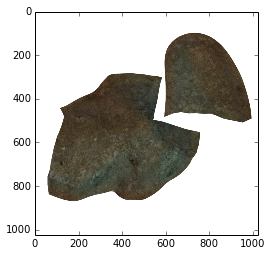

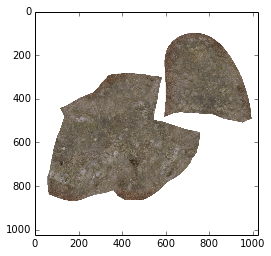

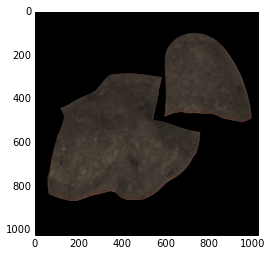

In [24]:
label, img = lighted_data[0]
plt.imshow(img)
plt.show()
plt.imshow(delighted_data[label])
plt.show()
plt.imshow(float_to_uint8(network.predict(np.array([img])))[0])
plt.show()